In [2]:
%load_ext autoreload
%autoreload 2


import os
os.chdir("../")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import data
import utils
from classifiers import OneVsAllClassifier
from stump_ensemble import StumpEnsemble
from tree_ensemble import TreeEnsemble

%matplotlib inline
sns.set(font_scale=1)
sns.set_style("white")
np.set_printoptions(precision=6, suppress=True)


# Feature importance visualization (barplots + heatmaps)

Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=plain n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
Best iter to take the model: 77
Ensemble of 78/150 trees restored: exps_diff_depth/2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=plain n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01.model.npy
Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=at_cube n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
Best iter to take the model: 2
Ensemble of 3/150 trees restored: exps_diff_depth/2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=at_cube n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01.model.npy
Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
Best iter to take the model: 45
Ensemble of 46/150 trees restored: exps_diff_depth/2019-08-11 14:28:04 dataset=bre

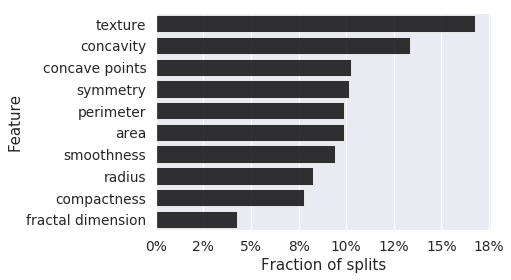

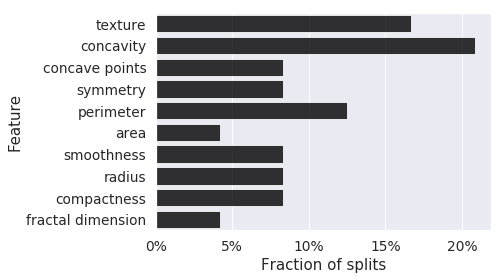

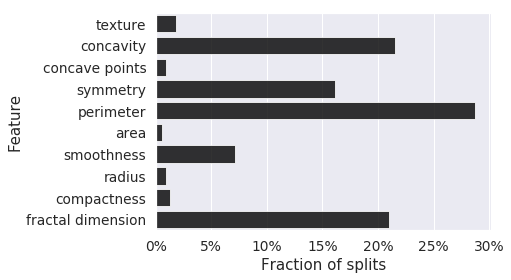

In [5]:
np.random.seed(1)
models = ['plain', 'at_cube', 'robust_bound']
# models = ['robust_bound']
exp_folder = 'exps_diff_depth'
weak_learner = 'tree'
tree_depth = 4
# datasets = ['breast_cancer', 'diabetes', 'cod_rna', 'mnist_1_5', 'mnist_2_6', 'fmnist_sandal_sneaker', 'gts_100_roadworks', 'gts_30_70']
# datasets = ['mnist_1_5', 'mnist_2_6', 'gts_100_roadworks', 'gts_30_70']
datasets = ['breast_cancer']
for dataset in datasets:
    _, _, X_test, y_test, eps = data.all_datasets_dict[dataset]()
    if dataset in data.datasets_img_shapes:
        flag_image_data = True
        final_shape = data.datasets_img_shapes[dataset]
        feature_names = np.arange(X_test.shape[1])
        sns.set(font_scale=0.4)
    else:
        flag_image_data = False
        final_shape = (1, X_test.shape[1])  # still important
        if dataset in data.datasets_feature_names:
            feature_names = data.datasets_feature_names[dataset]
        else:
            feature_names = ['f' + str(i) for i in np.arange(X_test.shape[1])]
        sns.set(font_scale=1.25)

    model_names = utils.get_model_names([dataset], models, exp_folder, weak_learner, tree_depth)
    for i, model_name in enumerate(model_names):
        print('Model name: {}'.format(model_name))
        model = model_name.split('model=')[1].split(' ')[0]
        eps = model_name.split('eps=')[1].split(' ')[0]
        
        model_path = model_name + '.model.npy'
        metrics_path = model_name + '.metrics'
        metrics = np.loadtxt(exp_folder + '/' + metrics_path)
        valid_errs, valid_adv_errs = metrics[:, 8], metrics[:, 10]
        # Model selection
        # best_iter = len(valid_errs) - 1  # otherwise, the counts are not comparable between different model types
        if model == 'plain':
            best_iter = np.argmin(valid_errs)
        elif model in ['at_cube', 'robust_bound', 'robust_exact']:
            best_iter = np.argmin(valid_adv_errs)
        else:
            raise ValueError('wrong model name')
        print('Best iter to take the model: {}'.format(best_iter))
        
        if weak_learner == 'stump':
            # the hyperparameters of recreated models do not matter (they matter only for training)
            ensemble = StumpEnsemble(weak_learner, 0, 0, 0, 0, 0)
        elif weak_learner == 'tree':
            ensemble = TreeEnsemble(weak_learner, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        else:
            raise ValueError('wrong weak learner')
        model_ova = OneVsAllClassifier([ensemble])
        model_ova.load('{}/{}'.format(exp_folder, model_path), iteration=best_iter)
        
        # importance visualizations for trees
        coords_per_tree = np.zeros(X_test.shape[1])
        for tree in ensemble.trees:
            if weak_learner == 'stump':
                coords_per_tree[tree.coord] += 1
            else:
                coords_curr_tree = np.array(tree.to_list(), dtype=int)[:, 6]
                for coord in coords_curr_tree:  # 6 is coord, 7 is min_loss
                    coords_per_tree[coord] += 1
        if flag_image_data:
            coords_per_tree = coords_per_tree.reshape(final_shape)
            coords_per_tree = coords_per_tree.sum(2) if len(final_shape) == 3 else coords_per_tree
            # cbar_kws = {'ticks': np.linspace(0, coords_per_tree.max(), 6)}
            # set annot=True for plotting also the number of splits
            ax = sns.heatmap(coords_per_tree, linewidths=0.0, square=True, cbar=False,
                             xticklabels=False, yticklabels=False)
        else:
            coords_per_tree = coords_per_tree / coords_per_tree.sum()
            coords_per_tree = pd.DataFrame({'Feature': feature_names, 'Fraction of splits': coords_per_tree})
            
            # Assumed that the plain model goes first among the three
            if model == 'plain':
                idx = coords_per_tree.sort_values(['Fraction of splits'], ascending=False).index
            coords_per_tree = coords_per_tree.loc[idx]
            
            ax = sns.barplot(x='Fraction of splits', y='Feature', data=coords_per_tree, color='black', alpha=0.8)
                             # palette="RdBu", linewidth=3.5, facecolor=(1, 1, 1, 0), edgecolor='.1')
            ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
        plot_name_save = 'count_coord_splits-exp={}-dataset={}-weak_learner={}-model={}'.format(
            exp_folder, dataset, weak_learner, model)
        plt.savefig('plots/{}.pdf'.format(plot_name_save), bbox_inches='tight', pad_inches=0.0,
                    transparent=True)
        plt.show()


# Feature importance visualization (gif)

(1990, 784)
Model name: 2019-07-08 18:04:42 dataset=mnist_2_6 weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=100 eps=0.300 max_depth=4 lr=1.0
Best iter to take the model: 150
Ensemble of 150 learners restored: exps_diff_depth/2019-07-08 18:04:42 dataset=mnist_2_6 weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=100 eps=0.300 max_depth=4 lr=1.0.model.npy


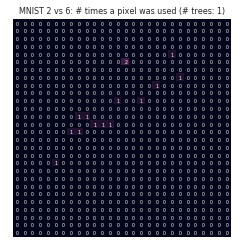

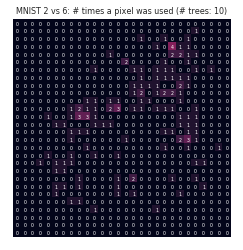

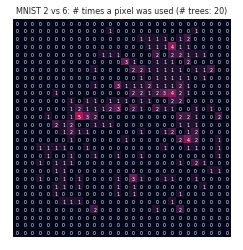

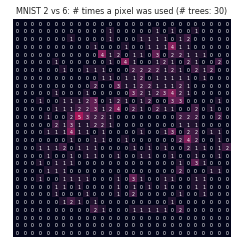

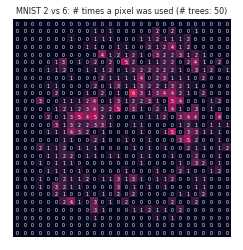

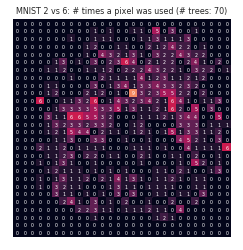

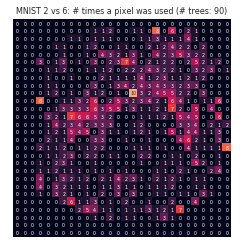

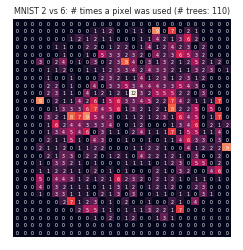

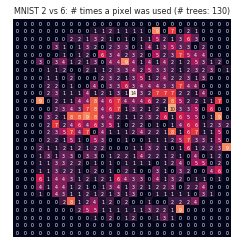

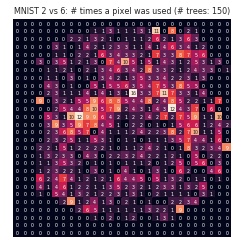

In [11]:
# models = ['plain', 'da_uniform', 'robust_bound']
models = ['robust_bound']
exp_folder = 'exps_diff_depth'
weak_learner = 'tree'
tree_depth = 4
# datasets = ['breast_cancer', 'diabetes', 'cod_rna', 'mnist_1_5', 'mnist_2_6', 'fmnist_sandal_sneaker', 'gts_100_roadworks', 'gts_30_70']
# datasets = ['mnist_1_5', 'mnist_2_6', 'gts_100_roadworks', 'gts_30_70']
datasets = ['mnist_2_6']
for dataset in datasets:
    _, _, X_test, y_test, eps = data.all_datasets_dict[dataset]()
    print(X_test.shape)
    if dataset in data.datasets_img_shapes:
        flag_image_data = True
        final_shape = data.datasets_img_shapes[dataset]
        feature_names = np.arange(X_test.shape[1])
        sns.set(font_scale=0.4)
    else:
        flag_image_data = False
        final_shape = (1, X_test.shape[1])  # still important
        if dataset in data.datasets_feature_names:
            feature_names = data.datasets_feature_names[dataset]
        else:
            feature_names = ['f' + str(i) for i in np.arange(X_test.shape[1])]
        sns.set(font_scale=1.25)

    model_names = utils.get_model_names([dataset], models, exp_folder, weak_learner, tree_depth)
    
    for i, model_name in enumerate(model_names):
        print('Model name: {}'.format(model_name))
        model = model_name.split('model=')[1].split(' ')[0]
        eps = model_name.split('eps=')[1].split(' ')[0]
        
        model_path = model_name + '.model.npy'
        metrics_path = model_name + '.metrics'
        metrics = np.loadtxt(exp_folder + '/' + metrics_path)
        valid_errs, valid_adv_errs = metrics[:, 8], metrics[:, 10]
        
        # Model selection
        # best_iter = len(valid_errs) - 1  # otherwise, the counts are not comparable between different model types
        if model == 'plain':
            best_iter = np.argmin(valid_errs)
        elif model in ['at_cube', 'robust_bound', 'robust_exact']:
            best_iter = np.argmin(valid_adv_errs)
        else:
            raise ValueError('wrong model name')
        print('Best iter to take the model: {}'.format(best_iter))
        
        if weak_learner == 'stump':
            # the hyperparameters of recreated models do not matter (they matter only for training)
            ensemble = StumpEnsemble(weak_learner, 0, 0, 0, 0, 0)
        elif weak_learner == 'tree':
            ensemble = TreeEnsemble(weak_learner, 0, 0, 0, 0, 0, 0, 0, 0, 0)
        else:
            raise ValueError('wrong weak learner')
        model_ova = OneVsAllClassifier([ensemble])
        model_ova.load('{}/{}'.format(exp_folder, model_path), iteration=best_iter)
        
        # importance visualizations for trees
        coords_per_tree = np.zeros(X_test.shape[1])
        idx_trees_to_visualize = [0, 9, 19, 29, 49, 69, 89, 109, 129, 149]
        # idx_trees_to_visualize = [149]
        for i_tree, tree in enumerate(ensemble.trees):
            if weak_learner == 'stump':
                coords_per_tree[tree.coord] += 1
            else:
                coords_curr_tree = np.array(tree.to_list(), dtype=int)[:, 6]
                for coord in coords_curr_tree:  # 6 is coord, 7 is min_loss
                    coords_per_tree[coord] += 1
            if i_tree in idx_trees_to_visualize:
                coords_per_tree_plt = coords_per_tree.reshape(final_shape)
                coords_per_tree_plt = coords_per_tree_plt.sum(2) if len(final_shape) == 3 else coords_per_tree_plt
                ax = sns.heatmap(coords_per_tree_plt, annot=True, linewidths=0.0, square=True, cbar=False,
                                 xticklabels=False, yticklabels=False, vmin=0, vmax=12)
                ax.set_title('MNIST 2 vs 6: # times a pixel was used (# trees: {})'.format(i_tree+1),
                             fontsize=8)
                plot_name_save = 'feature_importance_gif-exp={}-dataset={}-weak_learner={}-model={}-{}'.format(
                    exp_folder, dataset, weak_learner, model, i_tree+1)
                plt.savefig('plots/{}.png'.format(plot_name_save), bbox_inches='tight', pad_inches=0.2,
                            transparent=False, dpi=300)
                plt.show()
        


# Analysis of the values of splitting thresholds

--- Dataset: breast_cancer ---
Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=plain n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=at_cube n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
Model name: 2019-08-11 14:28:04 dataset=breast_cancer weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=10 eps=0.300 max_depth=4 lr=0.01
--- Dataset: mnist_1_5 ---
Model name: 2019-08-11 14:28:05 dataset=mnist_1_5 weak_learner=tree model=plain n_train=-1 n_trials_coord=784 eps=0.300 max_depth=4 lr=0.2
Model name: 2019-08-11 14:28:05 dataset=mnist_1_5 weak_learner=tree model=at_cube n_train=-1 n_trials_coord=784 eps=0.300 max_depth=4 lr=0.2
Model name: 2019-08-11 14:28:05 dataset=mnist_1_5 weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=784 eps=0.300 max_depth=4 lr=0.2
--- Dataset: mnist_2_6 ---
Model name: 2019-08-11 14:28:05 dataset=mnist_2_6 w

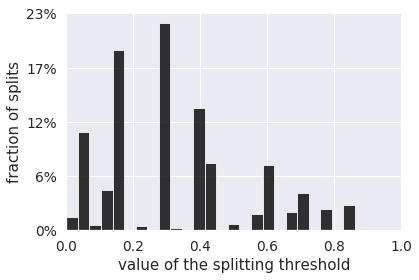

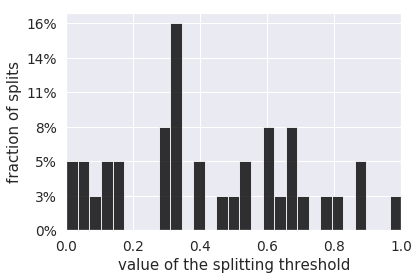

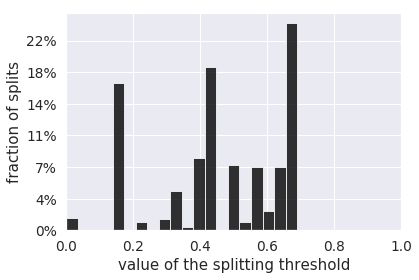

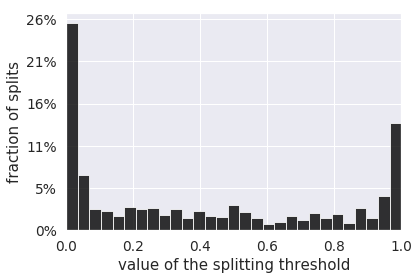

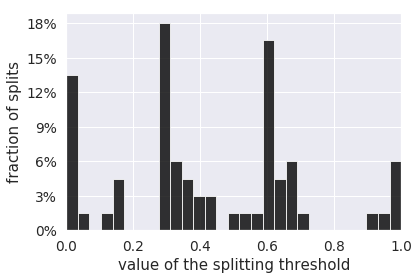

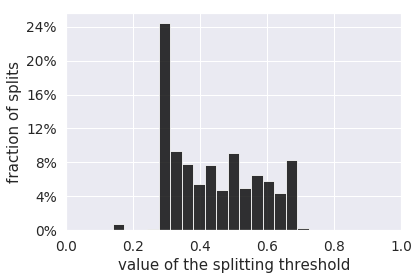

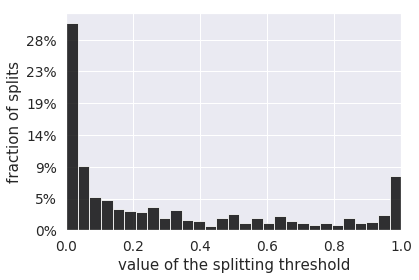

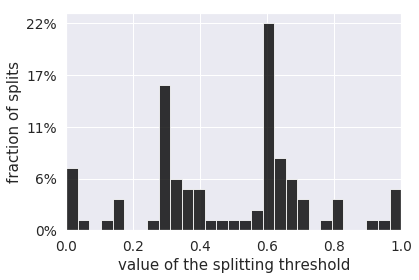

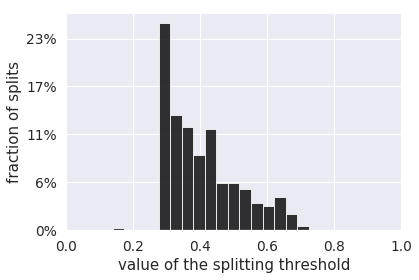

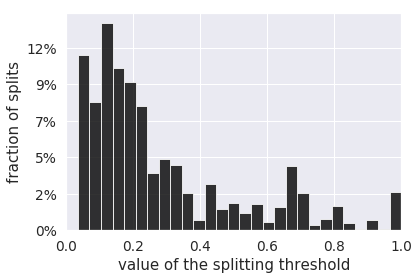

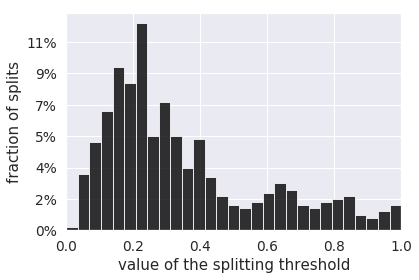

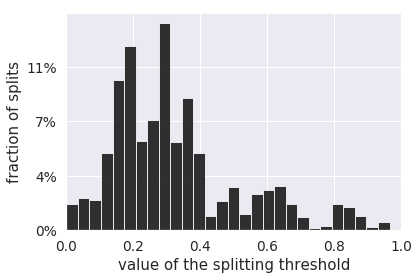

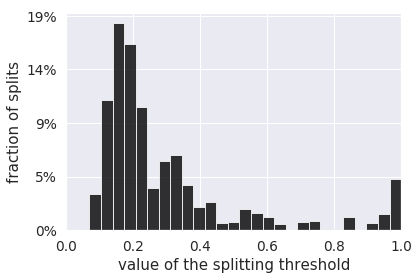

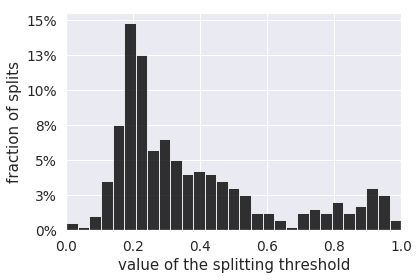

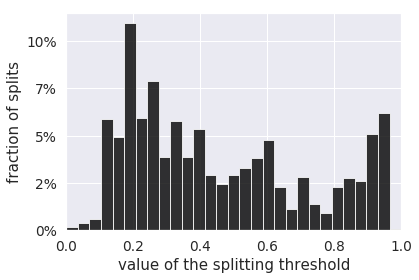

In [72]:
np.random.seed(1)
models = ['plain', 'at_cube', 'robust_bound']
# models = ['plain']
exp_folder = 'exps_diff_depth'
weak_learner = 'tree'
tree_depth = 4
# datasets = ['breast_cancer', 'diabetes', 'cod_rna', 'mnist_1_5', 'mnist_2_6', 'fmnist_sandal_sneaker', 'gts_100_roadworks', 'gts_30_70']
datasets = ['breast_cancer', 'mnist_1_5', 'mnist_2_6', 'gts_100_roadworks', 'gts_30_70']  # tabular datasets are also possible
# datasets = ['gts_30_70']  
for dataset in datasets:
    print('--- Dataset: {} ---'. format(dataset))
    _, _, X_test, y_test, eps = data.all_datasets_dict[dataset]()
    model_names = utils.get_model_names([dataset], models, exp_folder, weak_learner, tree_depth)
    
    sns.set(font_scale=1.25)
    for i, model_name in enumerate(model_names):
        print('Model name: {}'.format(model_name))
        dataset = model_name.split('dataset=')[1].split(' ')[0]
        model = model_name.split('model=')[1].split(' ')[0]
        weak_learner = model_name.split('weak_learner=')[1].split(' ')[0]
        eps = model_name.split('eps=')[1].split(' ')[0]
        
        model_path = model_name + '.model.npy'
        metrics_path = model_name + '.metrics'
        metrics = np.loadtxt(exp_folder + '/' + metrics_path)
        valid_errs, valid_adv_errs = metrics[:, 8], metrics[:, 10]
        # Model selection
        # best_iter = len(valid_errs) - 1  # otherwise, the counts are not comparable between different model types
        if model == 'plain':
            best_iter = np.argmin(valid_errs)
        elif model in ['at_cube', 'robust_bound', 'robust_exact']:
            best_iter = np.argmin(valid_adv_errs)
        else:
            raise ValueError('wrong model name')
        
        model_data = np.load(exp_folder + '/' + model_path)
        bs, n_bs = [], 0
        for i_tree in model_data[0].keys():
            if i_tree <= best_iter:
                thresholds_tree = model_data[0][i_tree][:, 5]
                bs.extend(thresholds_tree)
                n_bs += len(thresholds_tree)
        bs = np.array(bs)
        
        # 30 bins is important so that the bin [1 - 8/255, 1] is empty.
        ax = sns.distplot(bs, kde=False, bins=np.linspace(0.0, 1.0, 30), 
                          hist_kws={'color': 'black', 'alpha': 0.8})
        # hist_kws={'color': 'blue', 'alpha': 0.75}
        ax.set_yticklabels(['{:.0%}'.format(x/n_bs) for x in ax.get_yticks()])
        ax.set_xlim(0.0, 1.0)
        ax.set_xlabel('value of the splitting threshold')
        ax.set_ylabel('fraction of splits')
        ax.set_xticks(np.linspace(0.0, 1.0, 6))
        ax.tick_params(which='both', width=2)
        # ax.grid(which='both', alpha=0.5, linestyle='--')
    
        plot_name_save = 'histogram_of_thresholds-dataset={}-weak_learner={}-model={}'.format(dataset, weak_learner, model)
        plt.savefig('plots/{}.pdf'.format(plot_name_save), bbox_inches='tight')
        plt.show()